In [291]:
import config
import os
import cv2
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob


import preprocessing
from feature_extraction import get_features_for_window
from character_training import load_model, square_patch
import config



In [276]:
filename = os.path.join(config.TEXT_PATH, '2/104.jpg')


In [277]:
image = cv2.imread(filename)
image.max()

197

In [278]:
preprocessing.preprocess(image)

array([[ 3.24620145,  2.84562926,  3.17860135, ...,  1.62416209,
         1.4628615 ,  1.41697259],
       [ 1.78018153,  1.57184852,  1.10292763, ..., -0.15605639,
        -0.82926442, -0.92811867],
       [ 0.77562672,  0.78365739,  0.24335438, ..., -1.20833292,
        -1.14174925, -1.00098877],
       ..., 
       [ 1.12660175,  1.07440992,  1.03286345, ...,  0.33738839,
         0.60889276,  0.65698238],
       [ 1.13485865,  1.02169907,  1.19614957, ...,  0.84700403,
         0.77577739,  0.69642026],
       [ 2.6073393 ,  2.30878404,  2.8521607 , ...,  2.21462792,
         2.23330368,  2.00973404]])

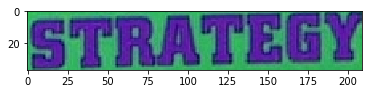

In [279]:
imgplot = plt.imshow(image)

In [280]:
preprocessed = preprocessing.preprocess(image)
preprocessed -= preprocessed.min()
preprocessed = (preprocessed / preprocessed.max())*255.0

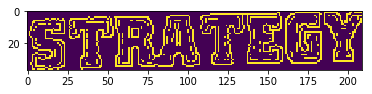

In [283]:
plt.imshow(cv2.Canny(image, 100, 200))

In [284]:
canny = cv2.Canny(image, 1, 10)
np.count_nonzero(np.gradient(canny[:,25]))


4

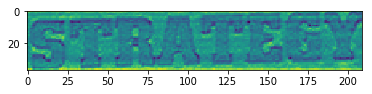

In [285]:
plt.imshow(preprocessed.astype('uint'))



In [286]:
preprocessed.astype('uint8').

SyntaxError: invalid syntax (<ipython-input-286-8f5b1e8951d8>, line 1)

In [302]:
def canny_separate(img, mark_image=False, ax=None):
    threshold1 = 100
    threshold2 = 200
    
    canny = cv2.Canny(img, threshold1, threshold2)
    
    edges = [0]
    max_width = 32
    canny[canny==255] = 1
    edge_threshold = np.percentile(canny.sum(axis=0), 10) # 10 is good!
    #print(edge_threshold)
    #print(canny.sum(axis=0)[20:30])
    ps = [1]
    for x in range(1, canny.shape[1]):
        width = x - edges[-1]
        prior = 0 if width < 8 else 0.7+(0.3*(width/max_width))
        #print(p)
        # maybe use np.count_nonzero(np.gradient(canny[:, x]))
        #print(edge_threshold/(1+np.count_nonzero(canny[:,x])))
        try:
            p = prior * edge_threshold/(canny[:,x].sum())
        except:
            if prior > 0:
                p = 1.0
        
        if p >= 1.0:
            edges.append(x)
            if mark_image:
                img[:, x, :] = 255
                try:
                    img[:, x+1, :] = 255
                except IndexError:
                    pass
        ps.append(p*25)
    if ax != None:
        ax[0].imshow(img)
        ax[1].imshow(canny)
        ax[2].plot(range(img.shape[1]), ps, color='r')
        ax[2].imshow(img)
    
        #ax[2].bar(range(canny.shape[1]),canny.sum(axis=0),1)
    
    return edges

In [303]:
dictionary = np.load(config.DICT_PATH)
try:
    logging.info('Trying to load model')
    model = load_model()
except FileNotFoundError:  # noqa
    logging.warning('Model not found, please run character training')


INFO:root:Trying to load model


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[0, 30]
['U']
[0, 27, 65, 100, 125]


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars


['L' 'T' 'I' 'I']
[0, 21]
['r']
[0, 37, 63, 84, 113]
['o' 'e' 'e' 'Y']
[0, 15, 72, 85, 98, 120, 152, 160]
['r' 'e' 'i' 'i' 'p' 'T' "'"]
[0, 23, 50, 75, 105, 140, 164]
['S' 'E' 'O' 'O' 'U' ')']
[0, 32, 52, 65, 97, 105, 132, 159]
['D' 'D' 'I' 'T' 'I' 'O' 'N']
[0, 19, 45, 57, 93, 109, 117, 125, 142]
['.' '.' '5' 'S' 'i' ':' '.' 'i']
[0, 21, 61, 125, 141, 150, 161, 171, 192]
['l' 'r' 'S' 'i' 'l' 'f' 'r' 'i']
[0, 37]
['L']
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 32, 41, 57]
['N' '.' "'"]
[0, 25, 51, 70]
['C' 'S' 'i']
[0]


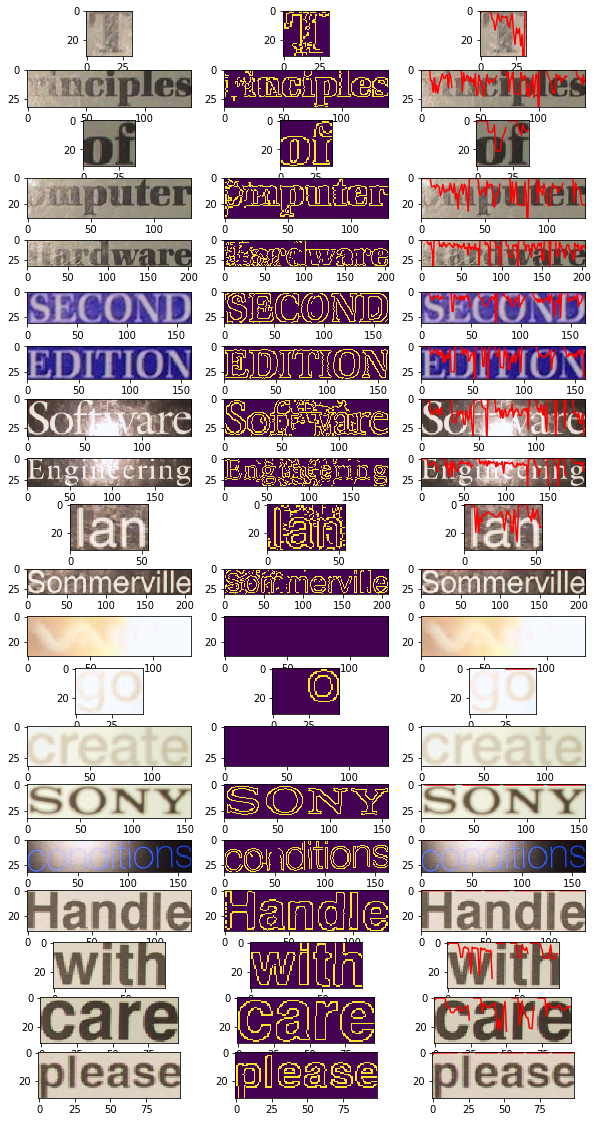

In [306]:
files = glob.glob(os.path.join(config.TEXT_PATH, '2/*.jpg'))[10:30]
fig, axes= plt.subplots(nrows=len(files), ncols=3, figsize=(10, 1*len(files)))
for i, file in enumerate(files):
    img=cv2.imread(file)
    scale = 32.0/img.shape[0]
    if scale > 1:
        interpolation = cv2.INTER_LINEAR
    else:
        interpolation = cv2.INTER_AREA

    try:
        resized = cv2.resize(img, None, fx=scale, fy=scale,
                             interpolation=interpolation)
    except Exception as e:
        logging.warning('Error scaling patch: {}'.format(e))
    else:
        edges = canny_separate(resized, False, axes[i, :]) 
        print(edges)
    
    features = []
    for i in range(len(edges)-1):
        window = square_patch(img[:,edges[i]:edges[i+1]])
        features.append(get_features_for_window(dictionary, window)[1].flatten())
    
    if features:
        predicted = model.predict(features)
        print(predicted)

    
    # now 